# MPS states and their properties
We start by expliclty constucting  Matrix product states (MPS)  
\begin{equation}
c_{i_0,i_1\cdots i_{N-2},i_{N-1}} = \textrm{tTr}\left(A^{i_1}A^{i_2}\cdots A^{i_{N-2}}A^{i_{N-1}}\right)
\end{equation} today we will study some of their properties and see how they help computing things. 

Let's start by trying to obtain a MPS for the random states we generated in last tutorials follwing the recipe that we have seen in books that is by performing iterated SVDs, 
![MPS_construction](../pictures/MPS.png "from doi:10.1088/1751-8121/aa6dc3")



In [1]:
import numpy as np 
import scipy.linalg as LA
def generate_random_state(N):
        dim_h =2**N
        init_state = np.zeros([dim_h,1])
        init_state[0]=1.
        random_h = np.array(np.random.rand(dim_h,dim_h)+1j*np.random.rand(dim_h,dim_h))
        random_h = random_h+random_h.T.conj()
        random_h = random_h/LA.norm(random_h)*N

        random_unitary =LA.expm(-1j*random_h)
        random_state=random_unitary@init_state
        return random_state
    
def compute_A_sigma_bulk(remaining_state,n,list_sigma):
        remaining_spins= len(remaining_state.shape)
        initial_shape =remaining_state.shape
        if n == 0 :
            #print('first')
            first_size =remaining_state.shape[0]
            second_size=np.prod(remaining_state.shape[1:])
        else:
            #print('bulk')
            first_size =remaining_state.shape[0]
            second_size=np.prod(remaining_state.shape[1:])
            remaining_state_c =remaining_state.reshape(first_size,second_size)
            first_size =np.prod(remaining_state.shape[0:2])
            second_size=np.prod(remaining_state.shape[2:])
            sigma_prev = list_sigma[n-1]
            remaining_state = sigma_prev@remaining_state_c
            remaining_state = remaining_state.reshape(initial_shape)
            
            
            
        remaining_state_matrix = remaining_state.reshape(
            first_size,second_size)
        
        A,sigma,rest = LA.svd(remaining_state_matrix,full_matrices
                             =False)
        
        chi=rest.shape[0]
        sigma =np.diag(sigma)
        if n == 0:
            rest_tensor =rest.reshape([rest.shape[0]]
                                  +list(remaining_state.shape[1:]))
        else:
            A =A.reshape(remaining_state.shape[0],remaining_state.shape[1],
                     A.shape[1])
            A = np.einsum('ij,jkl->ikl',LA.pinv(list_sigma[n-1]),A)
            rest_tensor =rest.reshape([rest.shape[0]]+
                                  list(remaining_state.shape[2:]))
        
        return A, sigma, rest_tensor
        
def state_reconstruct_einsum(list_A,list_sigma):
    N =len(list_A)
    avail_index = 'abcdefghlmnopqrstuvz'
    first_piece = list_A_tensors[0]
    for n in range(N-1):
        if n ==0:
            first_piece=np.einsum('ab,bd->ad',first_piece,list_sigma_tensors[n])
        else: 
            #print(first_piece.shape)
            #print(list_sigma_tensors[n].shape)
            num_left_indices=len(first_piece.shape)
            einsum_index=avail_index[0:num_left_indices]
            einsum_index+=','+avail_index[num_left_indices-1:num_left_indices+1]
            einsum_index+='->'+avail_index[0:num_left_indices-1]+avail_index[
               num_left_indices]
            #print(einsum_index)
            first_piece=np.einsum(einsum_index,
                                      first_piece,list_sigma_tensors[n])
        print('contracting '+str(n))
        num_left_indices=len(first_piece.shape)
        einsum_index=avail_index[0:num_left_indices]
        next_piece = list_A_tensors[n+1]
        other_index=len(next_piece.shape)
        einsum_index = einsum_index+','+avail_index[num_left_indices-1:
                    num_left_indices+other_index-1]
        einsum_index += '->'+avail_index[0:num_left_indices-1]+ avail_index[
            num_left_indices:num_left_indices+other_index-1]
        #print(einsum_index)
        first_piece =np.einsum(einsum_index,first_piece,next_piece)    
    return first_piece
def state_reconstruct_matmult(list_A,list_sigma):
    N =len(list_A)
    #print(N)
    list_d =[]
    list_d.append(list_A[0].shape[1])
    mat_left= list_A[0]
    for n in range(1,N-1):
        #print(n)
        mat_left = mat_left@list_sigma[n-1]
        mat_left = mat_left@list_A[n].reshape(list_A[n].shape[0],list_A[n].shape[1]*list_A[n].shape[2])
        mat_left = mat_left.reshape(mat_left.shape[0]*list_A[n].shape[1],list_A[n].shape[2])
        list_d.append(list_A[n].shape[1])
    
    mat_left = mat_left@list_sigma[N-2]
    mat_left = mat_left@list_A[N-1]
    list_d.append(list_A[N-1].shape[1])
    mat_left = mat_left.reshape(list_d)
    return mat_left


def create_MPS(N,state):
    remaining_state =state
    list_A_tensors =[]
    list_sigma_tensors =[]
    for n in range(N-1):
    #print(n)
        A,sigma,rest=compute_A_sigma_bulk(remaining_state,n,list_sigma_tensors)
    
        remaining_state =rest
    #print(rest.shape)
        list_A_tensors.append(A)
        list_sigma_tensors.append(sigma)

    
    list_A_tensors.append(rest)
    return list_A_tensors, list_sigma_tensors

# Playing with MPS
Even though in real life we will never have the full state of a quantum many-body system (since it is exponentially hard), we can play a bit with specific examples 

Now let start generating some interesting states and obtain their MPS decomposition. Let's first generate the $W$ state:  
$$ |W  \rangle =\frac{1}{\sqrt{N}}\sum_{n=1}^{N} |0 \cdots 0 1_n 0\cdots 0\rangle  $$

In [2]:
N=10
d=2

w_state = np.zeros(d**N)
dimensions =[d]*N
w_state = w_state.reshape(dimensions)
for k in range(N):
    vector =[int(0)]*N
    vector[k]=int(1)
    #print(vector)
    w_state[tuple(vector)]=1.       


#for k in range(d): 
#    for j in range(d):
#         for l in range(d):
#                for m in range(d):
#                    print('[' + str(l)+','+str(j)+','+str(k)+','+str(m)+']')
#                    print(w_state[m,l,j,k])

w_state = w_state/np.sqrt(N)
print(LA.norm(w_state.reshape(d**N)))


1.0


Let' s transform it into an MPS using the function defined abvove

In [3]:
list_A_tensors,list_sigma_tensors =create_MPS(N,w_state)
recontructed_state_mat_mult = state_reconstruct_matmult(list_A_tensors,list_sigma_tensors)
recontructed_state_mat_mult
np.max(w_state-recontructed_state_mat_mult)

4.996003610813204e-16

Let's have a look to the singular value of the $|W \rangle $ state

In [4]:
cut_off =1.e-12
for n in range(N-1):
    eig_rdm =np.diag(list_sigma_tensors[n])
    #print(eig_rdm)
    mask_sl=np.greater_equal(eig_rdm,cut_off)
    non_zero_eig= eig_rdm[mask_sl]
    print(non_zero_eig)
    print(np.sum(non_zero_eig**2))
    

[0.9486833  0.31622777]
1.0000000000000002
[0.89442719 0.4472136 ]
1.0
[0.83666003 0.54772256]
1.0
[0.77459667 0.63245553]
1.0
[0.70710678 0.70710678]
0.9999999999999997
[0.77459667 0.63245553]
1.0
[0.83666003 0.54772256]
1.0
[0.89442719 0.4472136 ]
0.9999999999999999
[0.9486833  0.31622777]
1.0


Now let's build the MPS for the state $WW$
$$ |W W \rangle =\frac{1}{\sqrt{N-1}}\sum_{n=1}^{N-1} |0 \cdots 0 1_n 1_{n+1} 0\cdots 0\rangle  $$

In [5]:
ww_state = np.zeros(d**N)
dimensions =[d]*N
ww_state = ww_state.reshape(dimensions)
for k in range(N-1):
    vector =[int(0)]*N
    vector[k]=int(1)
    vector[k+1]=int(1)
    #print(vector)
    ww_state[tuple(vector)]=1.       


#for k in range(d): 
#    for j in range(d):
#         for l in range(d):
#                for m in range(d):
#                    print('[' + str(l)+','+str(j)+','+str(k)+','+str(m)+']')
#                    print(w_state[m,l,j,k])

ww_state = ww_state/np.sqrt(N-1)
print(LA.norm(ww_state.reshape(d**N)))


0.9999999999999999


In [ ]:
list_A_tensors_ww,list_sigma_tensors_ww =create_MPS(N,ww_state)
recontructed_state_mat_mult = state_reconstruct_matmult(list_A_tensors_ww,list_sigma_tensors_ww)
np.max(ww_state-recontructed_state_mat_mult)

In [6]:
cut_off =1.e-12
for n in range(N-1):
    eig_rdm =np.diag(list_sigma_tensors[n])
    #print(eig_rdm)
    mask_sl=np.greater_equal(eig_rdm,cut_off)
    non_zero_eig= eig_rdm[mask_sl]
    print(non_zero_eig)
    print(np.sum(non_zero_eig**2))
    

[0.9486833  0.31622777]
1.0000000000000002
[0.89442719 0.4472136 ]
1.0
[0.83666003 0.54772256]
1.0
[0.77459667 0.63245553]
1.0
[0.70710678 0.70710678]
0.9999999999999997
[0.77459667 0.63245553]
1.0
[0.83666003 0.54772256]
1.0
[0.89442719 0.4472136 ]
0.9999999999999999
[0.9486833  0.31622777]
1.0


Now define a function that performs the truncation on the MPS you have obtained

In [7]:
def truncate_mps(list_A,list_s,cut_off):
    new_list_A =[]
    new_list_s =[]
    old_list_A =np.copy(list_A)
    for k in range(len(list_A)-1):
        eig_diag = np.diag(list_s[k])
        mask_sl=np.greater_equal(np.abs(eig_diag),cut_off)
        #print(k)
        print (len(mask_sl))
        if k==0:
            new_list_A.append(old_list_A[k][:,mask_sl])
            old_list_A[k+1]=list_A[k+1][mask_sl,:,:]
        else:
            new_list_A.append(old_list_A[k][:,:,mask_sl])
            if k< N-2:
                old_list_A[k+1] = old_list_A[k+1][mask_sl,:,:]
            else:
                old_list_A[k+1] = old_list_A[k+1][mask_sl,:]

        new_list_s.append(list_s[k][np.ix_(mask_sl, mask_sl)])
    
    new_list_A.append(old_list_A[k+1])
    return new_list_A, new_list_s

cut_off =1.e-12
new_list_A,new_list_sigma =truncate_mps(list_A_tensors,list_sigma_tensors,cut_off)

2
4
8
16
32
16
8
4
2


/home/luca/anaconda3/lib/python3.9/site-packages/numpy/lib/function_base.py:804: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return array(a, order=order, subok=subok, copy=True)


In [8]:
new_list_sigma[5]

array([[0.77459667, 0.        ],
       [0.        , 0.63245553]])

In [9]:
recontructed_state_mat_mult = state_reconstruct_matmult(new_list_A,new_list_sigma)
recontructed_state_mat_mult
np.max(w_state-recontructed_state_mat_mult)

4.996003610813204e-16

# Matrix product operators

Now let's define a vector of operators, $v^i_{a,b} = \sigma^i_{a,b}$ where we select only a 2-dimensional subspace of the operator space, say $1, \sigma_z$

In [10]:
operators_vect =np.zeros([d,2,2])
identity = np.eye(2)
sigma_x = np.array([[0.,1.],[1.,0.]])
sigma_y = np.array([[0.,-1.j],[1.j,0.]])
sigma_z = np.array([[1.,0.],[0.,-1.]])
operators_vect[0,:,:]=identity
operators_vect[1,:,:]=sigma_z

Now contract the first leg of the operator tensor with the physical leg of the MPS for the $WW$ state, what do you obtain? If you now change the operator space and put a $\sigma_x$ instead of a $\sigma_z$ what do you obtain? Now also consider that if you want to have a sum of operators without the normalization factor of your state, you need to re-normalize the state, what are the correct factors?

In [ ]:
def define_MPO_from_MPS_and_op_vect(operators_vect, list_A,list_sigma,normalization):
    list_O =[]
    N= len(list_A)
    for n in range(N-1):
            A_times_sigma = np.einsum('...j,jk->...k',list_A[n],list_sigma[n])
            print(A_times_sigma.shape)
            if n==0:
                O = np.einsum('kr,kab->rab',A_times_sigma,operators_vect*normalization)
            else:
                O = np.einsum('lkr,kab->lrab',A_times_sigma,operators_vect)
            
            list_O.append(O)
    list_O.append(np.einsum('lk,kab->lab',list_A[N-1],operators_vect))
    return list_O
    
list_O_sigma_z = define_MPO_from_MPS_and_op_vect(operators_vect, new_list_A,new_list_sigma,np.sqrt(N))
operators_vect[1,:,:]=sigma_x
new_list_A_ww,new_list_sigma_ww =truncate_mps(list_A_tensors_ww,list_sigma_tensors_ww,cut_off)
list_O_sigma_xx = define_MPO_from_MPS_and_op_vect(operators_vect, new_list_A_ww,new_list_sigma_ww,np.sqrt(N-1))


Now we can put the two operators together by creating states on a local Hilbert space with dimension $3$, the state will be the sum of $W$ and $WW$ but on different physical states:
$$ |W W \rangle =-\sum_{n=1}^{N-1} |0 \cdots 0 1_n 1_{n+1} 0\cdots 0\rangle  +\lambda \sum_{n=1}^{N} |0 \cdots 0 2_n 0 0\cdots 0\rangle  $$

In [ ]:
d=3
v_lambda =0.1
ww_p_w_state = np.zeros(d**N)
dimensions =[d]*N
ww_p_w_state = ww_p_w_state.reshape(dimensions)
for k in range(N-1):
    vector =[int(0)]*N
    vector[k]=int(1)
    vector[k+1]=int(1)
    #print(vector)
    ww_p_w_state[tuple(vector)]=-1.  

for k in range(N):
    vector =[int(0)]*N
    vector[k]=int(2)
    ww_p_w_state[tuple(vector)]=v_lambda

list_A_tensors_ww_p_w,list_sigma_tensors_ww_p_w =create_MPS(N,ww_p_w_state)
recontructed_state_mat_mult = state_reconstruct_matmult(list_A_tensors_ww_p_w,list_sigma_tensors_ww_p_w)
np.max(ww_p_w_state-recontructed_state_mat_mult)
new_list_A_ww_p_w,new_list_sigma_ww_p_w =truncate_mps(list_A_tensors_ww_p_w,list_sigma_tensors_ww_p_w,cut_off)

In [ ]:
operators_vect =np.zeros([d,2,2])
operators_vect[0,:,:]=identity
operators_vect[1,:,:]=sigma_x
operators_vect[2,:,:]=sigma_z
list_O_sigma_xx_p_z = define_MPO_from_MPS_and_op_vect(operators_vect, 
                                                      new_list_A_ww_p_w,new_list_sigma_ww_p_w,1)


In [ ]:
def build_and_diagonalize_H(N,v_lambda):
    identity = np.eye(2)
    sigma_x = np.array([[0.,1.],[1.,0.]])
    sigma_z = np.array([[1.,0.],[0.,-1.]])
    H = -np.kron(sigma_x,sigma_x) + v_lambda*(np.kron(identity,sigma_z)+  np.kron(sigma_z,identity))
    for n in range(3,N+1):
        H = np.kron(H,np.eye(2)) + np.kron(np.eye(2**(n-2)),-np.kron(sigma_x,sigma_x)) + (
        v_lambda*(np.kron(np.eye(2**(n-1)),sigma_z)))
                                                                                                                                                  
    eig_H,U_H =LA.eigh(H)
    return H, eig_H, U_H

In [ ]:
H,_,_ = build_and_diagonalize_H(N,v_lambda)

In [ ]:
def reconstruct_operator_from_MPO(list_O):
    N=len(list_O)
    op_left_o = list_O[0].transpose(1,2,0)
    for k in range(N-2):
        #print(k+1)

        op_right =list_O[k+1]
        #print(op_left_o.shape)
        #print(op_right.shape)
        op_left = (op_left_o.reshape(np.prod(op_left_o.shape[0:2]),op_left_o.shape[2])@
                       op_right.reshape(op_right.shape[0],np.prod(op_right.shape[1:])))
        op_left = op_left.reshape(op_left_o.shape[0],op_left_o.shape[1],
                                  op_right.shape[1],op_right.shape[2],op_right.shape[3])
        op_left = op_left.transpose(0,3,1,4,2)
        op_left =op_left.reshape(op_left.shape[0]*op_left.shape[1],op_left.shape[2]*op_left.shape[3],op_left.shape[4])
        op_left_o =op_left

    op_right =list_O[N-1]
    op_tot = (op_left_o.reshape(np.prod(op_left_o.shape[0:2]),op_left_o.shape[2])@
              op_right.reshape(op_right.shape[0],np.prod(op_right.shape[1:])))
    op_tot= op_tot.reshape(op_left_o.shape[0],op_left_o.shape[1],
                                  op_right.shape[1],op_right.shape[2])
    op_tot = op_tot.transpose(0,2,1,3)
    op_tot =op_tot.reshape(op_tot.shape[0]*op_tot.shape[1],op_tot.shape[2]*op_tot.shape[3])

    return op_tot

H_reconstructed = reconstruct_operator_from_MPO(list_O_sigma_xx_p_z)
np.max(H-H_reconstructed)

# Gauge fixing MPS
In this notebook we will follow the excelent page on TEDB by Glen Evenbly on tensors.net
https://www.tensors.net/mps

We start by initializing random MPS tensors, in the gauge in which the central site are
the Schmidt weight, the need of two different tensors $A$ and $B$ namely the use of a state with a non-trivial unit cell will become clearer in the following.
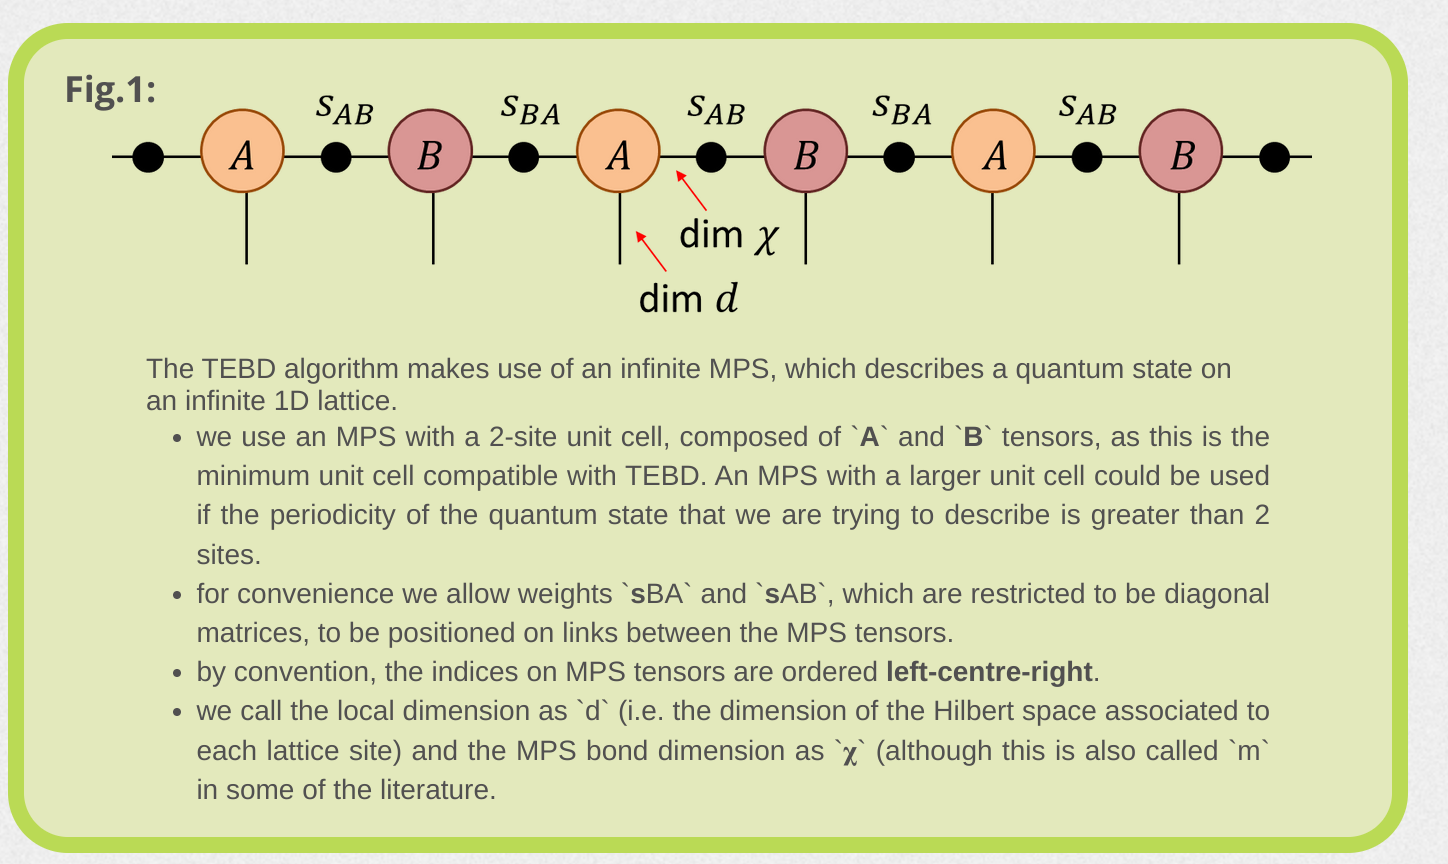

In [ ]:
# from tensors.net
import numpy as np
# initialize tensors
d = 2
chi = 10
A = np.random.rand(chi, d, chi)
B = np.random.rand(chi, d, chi)
sAB = np.ones(chi) / np.sqrt(chi)  # set trivial initial weights
sBA = np.ones(chi) / np.sqrt(chi)  # set trivial initial weights


We now want to minimize the expectation value of a local Hamiltonian, since we are constructing an infinite sate by aternating $A$ and $B$ matrices, this could seem uncomputatble, but check the screenshot from tensors.net again you have several options. 

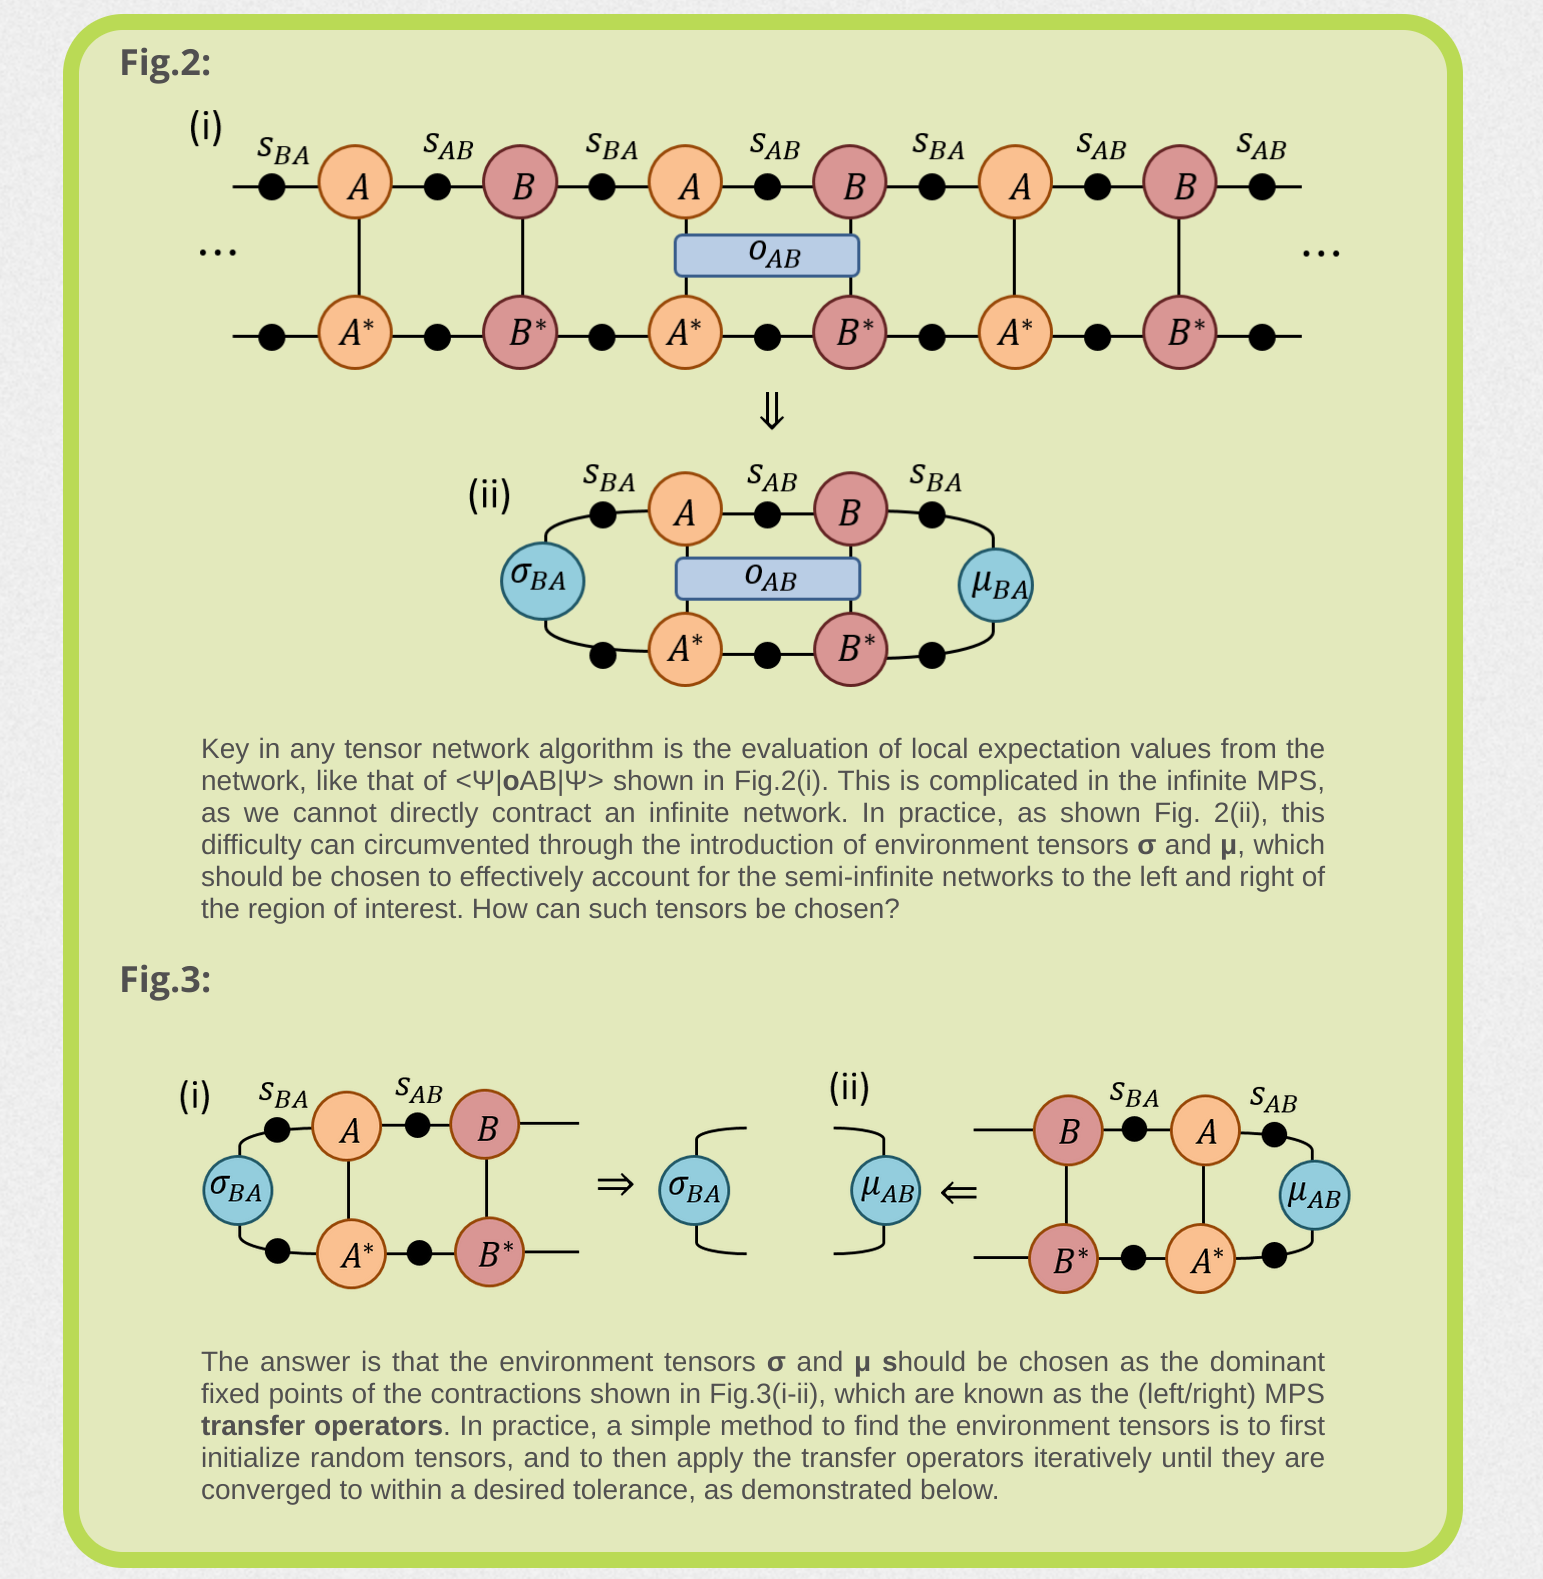
The first is to start contracting the state from the left, with some initial random guess for the left environment,  and keep contracting untill the left environement converges to something,practically builiding a power method for the transfer matrix $E(AB)$ 

In [ ]:
from scipy import linalg as LA



Write the lines of code with einsum that perform the desider multiplications, you cain either write several lines or just one function call, remember to use optimize=einsum_path, with the appropriately defined einsum_path (check the documentation), the two strategies need to provide the same result,check it.

In [ ]:
sigma_BA = np.random.rand(chi,chi)

sigma_BAp=np.diag(sBA)@sigma_BA@np.diag(sBA)
sigma_BApp=np.einsum('ab,bir->air',sigma_BAp,A)
sigma_BAppp=np.einsum('air,aiq->rq',sigma_BApp,A.conj())
Bp= np.einsum('lr,rip->lip',np.diag(sAB),B)
sigma_BApppp =np.einsum('ld,lir->dir',sigma_BAppp,Bp)
final_result = np.einsum('dir,diq->rq',sigma_BApppp,Bp.conj())


#alternate in just one line 
list_tensors_BA = [sigma_BA,np.diag(sBA) , np.diag(sBA), A, A.conj(), 
                np.diag(sAB) , np.diag(sAB),B, B.conj()]
einsu_indices_BA ='ij,li,jk,kpq,lpr,qs,rt,svw,tvz->wz'
einsum_path_BA = ['einsum_path',(0,1),(0,7),(0,6),(0,5),(0,4),(0,3),(0,2),(0,1)]
final_result_2 =np.einsum(einsu_indices_BA,*list_tensors_BA,optimize=einsum_path_BA)
    
np.max(final_result-final_result_2)

Now we are ready to perform the desired calculation  write the iterative application of the $E(A,B)$ to the random initial state, be carefull you need to normalize the resulting vector  after every multiplication step to avoid accumulations and numerical run-out

In [ ]:
tol =1e-10
list_tensors_BA[0] =np.random.rand(chi,chi)
for k in range(1000):
        sigma_BA_new =  np.einsum(einsu_indices_BA,*list_tensors_BA,optimize=einsum_path_BA)# contract transfer operator
        sigma_BA_new = sigma_BA_new / np.trace(sigma_BA_new) # normalize
      
        if LA.norm(list_tensors_BA[0] - sigma_BA_new) < tol:  # check convergence
            print('success!')
            print(k)
            break    
        list_tensors_BA[0] = sigma_BA_new
        
 



Once we have the left $\sigma_{BA}$ the $\sigma_{AB} is obviously obtained by multuplying for the relevant tensors, write the code below

In [ ]:
sigma_BA = sigma_BA_new
list_tensors_AB = [sigma_BA, np.diag(sBA) , np.diag(sBA), A, A.conj()]
einsu_indices_AB ='ij,li,jk,kpq,lpr->qr'
einsum_path_AB = ['einsum_path',(0,1),(0,3),(0,2),(0,1)]
sigma_AB =np.einsum(einsu_indices_AB,*list_tensors_AB,optimize=einsum_path_AB)


This can obvioulsy be accelerated by understanding that we are trying to find the largest eigenvector of $E(AB)$ and use a sparse diagonalization routine write it below

In [ ]:
from scipy.sparse.linalg import LinearOperator,eigs
def multiply_by_vector_left(v0, sAB,sBA, A, B):
    chi =A.shape[0]
    v0_t =v0.reshape(chi,chi)
    list_tensors_BA = [v0_t,np.diag(sBA) , np.diag(sBA), A, A.conj(), 
                np.diag(sAB) , np.diag(sAB),B, B.conj()]
    einsu_indices_BA ='ji,il,jk,kpq,lpr,qs,rt,svw,tvz->wz'
    einsum_path_BA = ['einsum_path',(0,1),(0,7),(0,6),(0,5),(0,4),(0,3),(0,2),(0,1)]
    def left_mult(v0):
        v0_t =v0.reshape(chi,chi)
        list_tensors_BA[0]=v0_t
        new_v =np.einsum(einsu_indices_BA,*list_tensors_BA,optimize=einsum_path_BA)
        return new_v.reshape(chi*chi)
    
    #v0=np.random.rand(chi**2)
    Dtemp, sigma_BA_new = eigs(LinearOperator((chi**2, chi**2), matvec=left_mult),
                      k=1, which='LM', v0=v0, tol=1e-10)

    sigma_BA = sigma_BA_new.reshape(chi,chi)
    sigma_BA = 0.5 * (sigma_BA + np.conj(sigma_BA.T))
    sigma_BA = sigma_BA / np.trace(sigma_BA)

    list_tensors_AB = [sigma_BA, np.diag(sBA) , np.diag(sBA), A, A.conj()]
    einsu_indices_AB ='ij,li,jk,kpq,lpr->qr'
    einsum_path_AB = ['einsum_path',(0,1),(0,3),(0,2),(0,1)]
    sigma_AB =np.einsum(einsu_indices_AB,*list_tensors_AB,optimize=einsum_path_AB)
    sigma_AB = sigma_AB / np.trace(sigma_AB)
    return sigma_BA,sigma_AB

v0 =np.random.rand(chi*chi)
sigma_BA,sigma_AB = multiply_by_vector_left(v0, sAB,sBA, A, B)

Now we are ready to fix the gauge in order to get the orthogonality center on the desired bond, 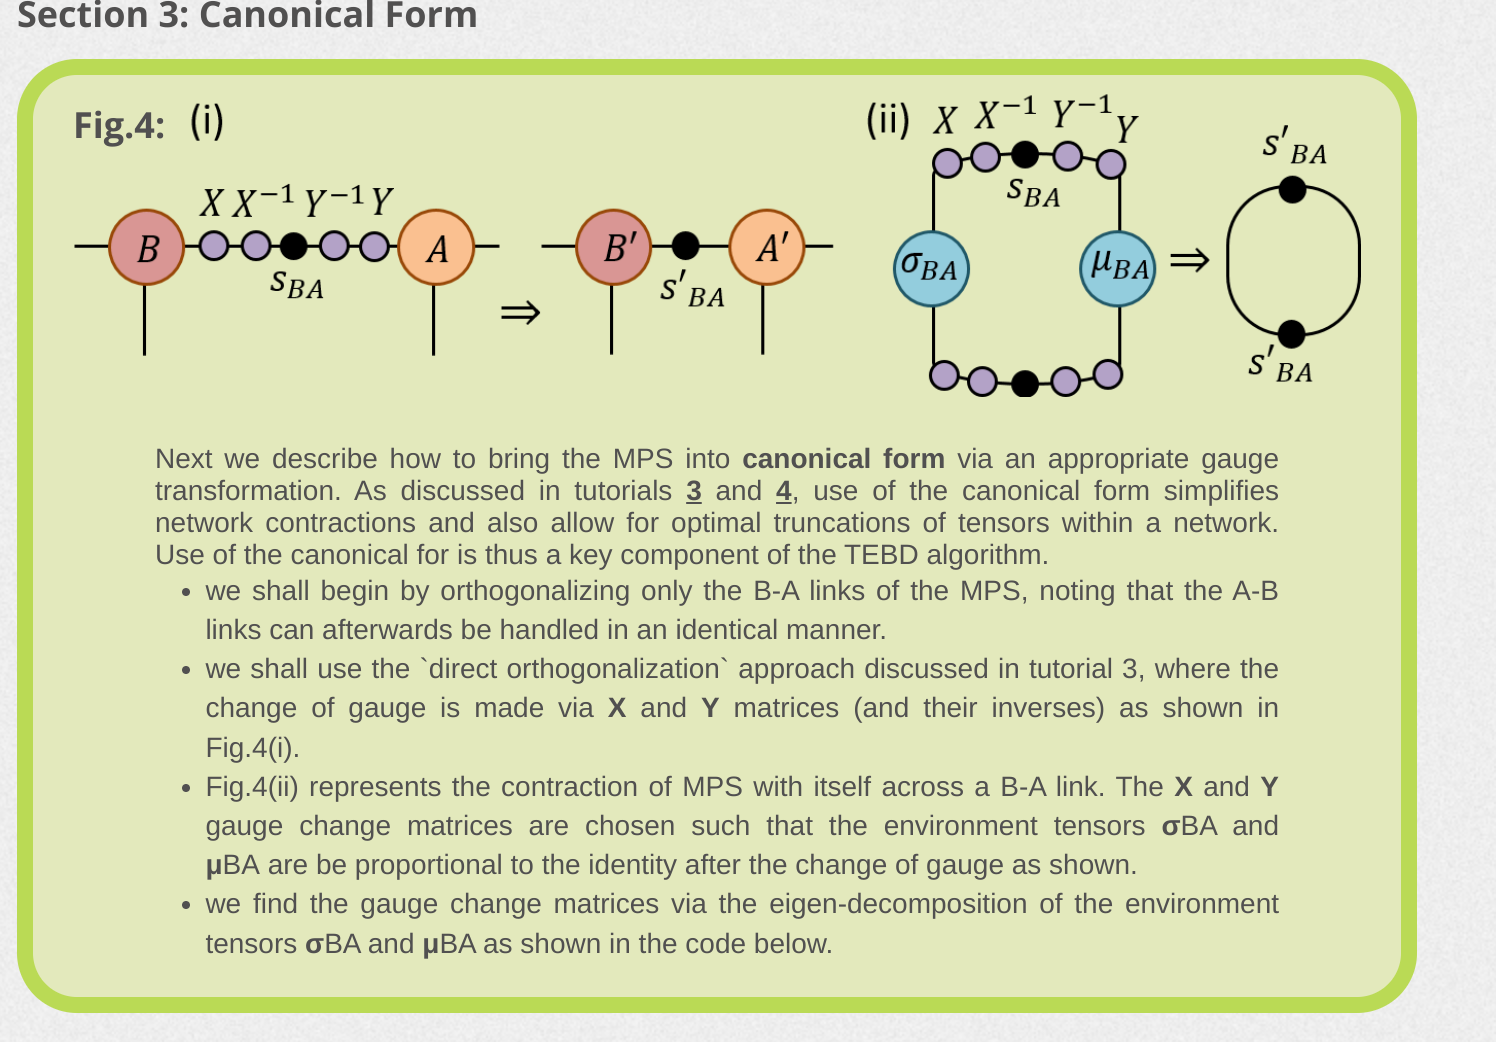

For this you immediately relize you also need the infinite contraction from the right, that you obtain with a similar function to the one above, write it down

In [ ]:
def multiply_by_vector_right(v0, sAB,sBA, A, B):
    chi =A.shape[0]
    v0_t =v0.reshape(chi,chi)
    list_tensors_BA = [v0_t,np.diag(sBA) , np.diag(sBA), B, B.conj(), 
                np.diag(sAB) , np.diag(sAB),A, A.conj()]
    einsu_indices_BA ='ij,li,kj,qpl,rpk,sq,tr,wvs,zvt->wz'
    einsum_path_BA = ['einsum_path',(0,1),(0,7),(0,6),(0,5),(0,4),(0,3),(0,2),(0,1)]
    def right_mult(v0):
        v0_t =v0.reshape(chi,chi)
        list_tensors_BA[0]=v0_t
        new_v =np.einsum(einsu_indices_BA,*list_tensors_BA,optimize=einsum_path_BA)
        return new_v.reshape(chi*chi)
    
    #v0=np.random.rand(chi**2)
    Dtemp, mu_BA_new = eigs(LinearOperator((chi**2, chi**2), matvec=right_mult),
                      k=1, which='LM', v0=v0, tol=1e-10)

    mu_BA = mu_BA_new.reshape(chi,chi)
    mu_BA = 0.5 * (mu_BA + np.conj(mu_BA.T))
    mu_BA = mu_BA / np.trace(mu_BA)

    list_tensors_AB = [mu_BA, np.diag(sBA) , np.diag(sBA), B, B.conj()]
    einsu_indices_AB ='ij,li,kj,qpl,rpk->qr'
    einsum_path_AB = ['einsum_path',(0,1),(0,3),(0,2),(0,1)]
    mu_AB =np.einsum(einsu_indices_AB,*list_tensors_AB,optimize=einsum_path_AB)
    mu_AB = mu_AB / np.trace(mu_AB)
    return mu_BA,mu_AB


In [ ]:
def orthogonal_center(sAB,A,B,sigma_AB,mu_AB):
    eig_sigma_ab,u_sigma_ab = LA.eigh(sigma_AB)
    #sigma_AB = u_sab @eig_sab @u_sab.conj().T
    #np.max(u_sab @np.diag(eig_sab) @u_sab.conj().T-sigma_AB)
    eig_mu_ab,v_mu_ab = LA.eigh(mu_AB)

    s_ab_prime = np.diag(np.sqrt(eig_sigma_ab))@u_sigma_ab.T@np.diag(
        sAB)@v_mu_ab@np.diag(np.sqrt(eig_mu_ab))
    u_s,s_s,vd_s =LA.svd(s_ab_prime)

    x = u_sigma_ab.conj()@LA.pinv(np.diag(np.sqrt(eig_sigma_ab)))@u_s
    y =vd_s@LA.pinv(np.diag(np.sqrt(eig_mu_ab)))@v_mu_ab.conj().T

    New_A = np.einsum('lpr,rq->lpq',A,x)
    New_B = np.einsum('lpr,ql->qpr',B,y)

    New_sAB =s_s
    return New_A,New_B,New_sAB
sigma_BA,sigma_AB = multiply_by_vector_left(v0,sAB,sBA, A, B)
mu_BA,mu_AB = multiply_by_vector_left(v0,sAB,sBA, A, B)

A,B,sAB = orthogonal_center(sAB,A,B,sigma_AB,mu_AB)
sigma_BA,sigma_AB = multiply_by_vector_left(v0,sAB,sBA, A, B)
mu_BA,mu_AB = multiply_by_vector_left(v0,sAB,sBA, A, B)

B,A,sBA = orthogonal_center(sBA,B,A,sigma_BA,mu_BA)
sigma_BA,sigma_AB = multiply_by_vector_left(v0,sAB,sBA, A, B)
mu_BA,mu_AB = multiply_by_vector_left(v0,sAB,sBA, A, B)
print(np.max(np.abs(sigma_AB-np.eye(chi)/chi)))
print(np.max(np.abs(mu_AB-np.eye(chi)/chi)))
print(np.max(np.abs(sigma_BA-np.eye(chi)/chi)))
print(np.max(np.abs(mu_BA-np.eye(chi)/chi)))

# Put everything together. 
Now consider a finite MPS given by the list of matrices above. Write a routine that given a random MPS,
1. Compute its left and right eigenvectors
2. Set the MPS in the right canonical form (use an iterative SVD starting from the right) 
3. Set the MPS in the left canonical form (use an iterative SVD starting from the left)
4. Put the MPS in the canonical form where each link is the orthogonal center of the network (Vidal mixed form)
5. Use the example of the finite creation of the MPS in order to understand how you could do it iteratively starting from the left or the right